# Batch Mode Speaker Verificaiton  

In [1]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import os
import sys
import pandas as pd
import pickle
import numpy as np

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [79]:
from batch_sv_system_utils import get_embeds, cosine_sim, compute_error, compute_eer

In [137]:
from utils import key2df, df2dict

embed_dir = "embeddings/voxc2_fbank64_voxc2untied_tdnn7_embeds/"
keys = pickle.load(open(embed_dir + "/sv_keys.pkl", "rb"))
sv_embeds = np.load(embed_dir + "/sv_embeds.npy")
key_df = key2df(keys)
id2idx, idx2id = df2dict(key_df) 

In [138]:
os.environ['KALDI_ROOT'] = "/dataset/muncok/kaldi/"
plda_model_dir = embed_dir + "plda_train/"

In [139]:
trial = pickle.load(open("trials/enr306/short_enr_test/trials.pkl", "rb"))

## Run Trial - Score fusion

In [140]:
t_idx = 30
enr_spk, enr_ids, adapt_trial, test_trial= trial[t_idx]

In [152]:
vT = 20
eT = 25
neT = 0.45

eer=0.0200, err=0.0360, fpr=0.0000, fnr=0.1800


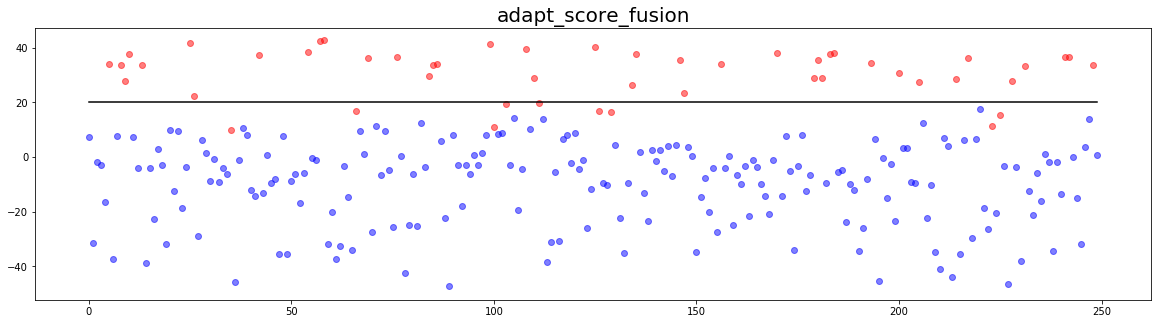

n_adapted:39, adapt_acc:1.000
eer=0.0230, err=0.1724, fpr=0.2267, fnr=0.0011


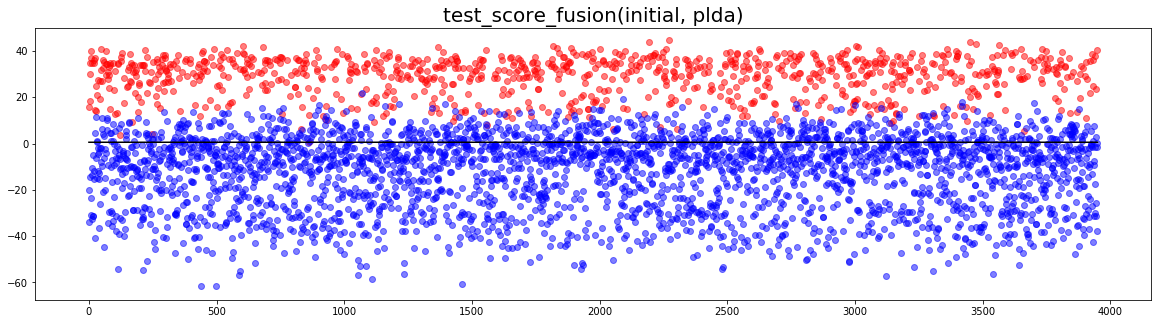

eer=0.0116, err=0.0129, fpr=0.0013, fnr=0.0494


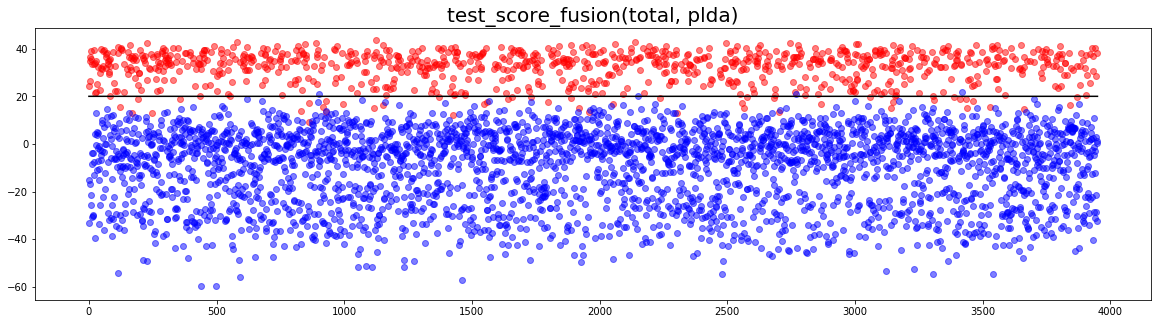

In [157]:
from batch_sv_system_utils import run_trial, plot_score 

# adapt trial
enr_embeds = get_embeds(enr_ids, sv_embeds, id2idx)
adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, id2idx)
adapt_scores = run_trial(enr_embeds, adapt_embeds, adapt_trial[1], threshold=vT,
                         plda_dir=plda_model_dir, 
                         title="adapt_score_fusion")
adapt_enr_idx = np.nonzero(adapt_scores.mean(0) > eT)
adapt_enr_embeds = adapt_embeds[adapt_enr_idx]
adapt_enr_acc = np.array(adapt_trial[1])[adapt_enr_idx].mean()
print("n_adapted:{}, adapt_acc:{:.3f}".format(len(adapt_enr_idx[0]), adapt_enr_acc))
### score fusion
total_enr_embeds = np.concatenate([enr_embeds, adapt_enr_embeds], axis=0)
### feat_fusion
# total_enr_embeds = np.concatenate([enr_embeds, adapt_enr_embeds], axis=0).mean(0, keepdims=True)

# test trial
test_embeds = get_embeds(test_trial[0], sv_embeds, id2idx)
# init_test_scores = run_trial(enr_embeds, test_embeds, test_trial[1], threshold=vT, 
#                              plot=True, title="test_score_fusion(initial)")
init_test_scores = run_trial(enr_embeds, test_embeds, test_trial[1], 
                                  plda_dir=plda_model_dir,
                                  plot=True, title="test_score_fusion(initial, plda)")

total_test_scores = run_trial(total_enr_embeds, test_embeds, test_trial[1], threshold=vT, 
                              plda_dir=plda_model_dir, 
                              plot=True, title="test_score_fusion(total, plda)")

### Score Calibration

In [158]:
val_set = pd.read_pickle("trials/enr306/validation_set.pkl")
cohort_embeds = get_embeds(val_set.sample(n=5000).index, sv_embeds, id2idx)

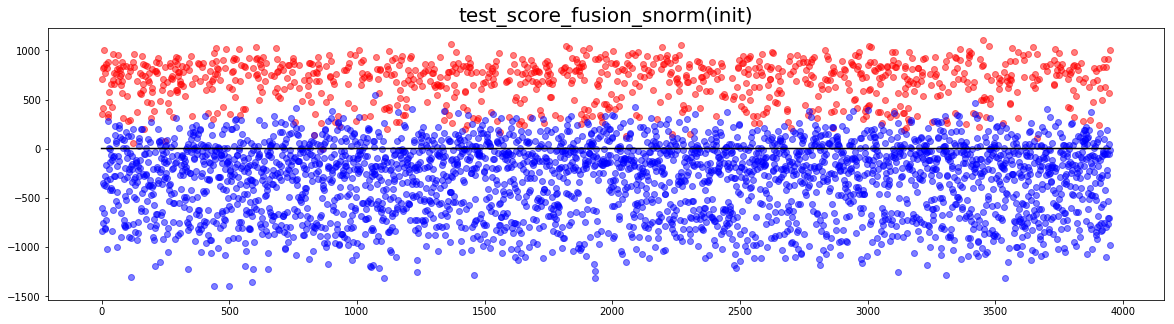

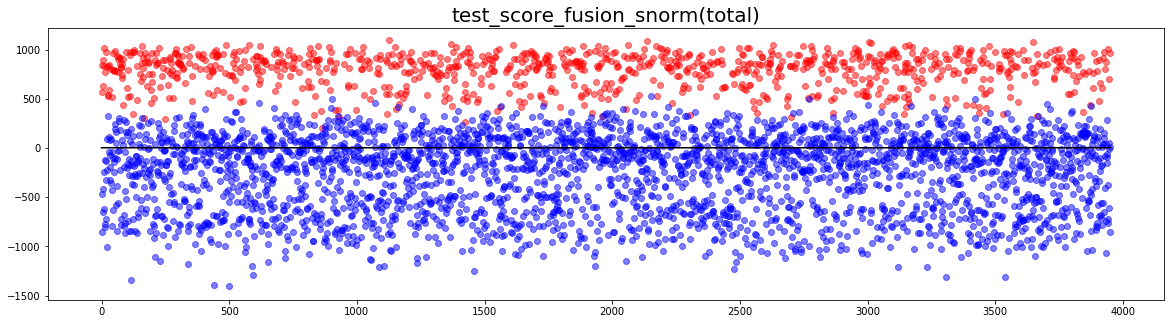

In [159]:
### init
enr_cohort_scores = cosine_sim(enr_embeds, cohort_embeds)
test_cohort_scores = cosine_sim(test_embeds, cohort_embeds)

enr_mean = enr_cohort_scores.mean(1).reshape(-1, 1)
enr_std = enr_cohort_scores.std(1).reshape(-1, 1)
test_mean = test_cohort_scores.mean(1).reshape(1, -1)
test_std = test_cohort_scores.std(1).reshape(1, -11)

norm_scores = ((init_test_scores - enr_mean)/enr_std + (init_test_scores - test_mean)/test_std)/2
eer, err, fpr, fnr = compute_error(norm_scores, pred, labels, verbose=True)
if verbose:
    print("eer={:.4f}, err={:.4f}, fpr={:.4f}, fnr={:.4f}".format(eer, err, fpr, fnr))

############################################################################

### total
enr_cohort_scores = cosine_sim(total_enr_embeds, cohort_embeds)
test_cohort_scores = cosine_sim(test_embeds, cohort_embeds)

enr_mean = enr_cohort_scores.mean(1).reshape(-1, 1)
enr_std = enr_cohort_scores.std(1).reshape(-1, 1)
test_mean = test_cohort_scores.mean(1).reshape(1, -1)
test_std = test_cohort_scores.std(1).reshape(1, -11)

tmp_scores = ((total_test_scores - enr_mean)/enr_std + (total_test_scores - test_mean)/test_std)/2

plot_score(tmp_scores.mean(0), test_trial[1], 3, "test_score_fusion_snorm(total)")

In [160]:
### Score Distribution 

neg_scores = total_test_scores.mean(0)[test_trial[1] == 0]
neg_trials = test_trial[0][test_trial[1] == 0]
hard_neg_idx = neg_scores.argsort()[-10:]
easy_neg_idx = neg_scores.argsort()[:10]

hard_neg_embeds = get_embeds([neg_trials[hard_neg_idx[-1]]], sv_embeds, id2idx)
easy_neg_embeds = get_embeds([neg_trials[easy_neg_idx[0]]], sv_embeds, id2idx)

np.quantile(cosine_sim(hard_neg_embeds, cohort_embeds), q=0.9)
np.quantile(cosine_sim(easy_neg_embeds, cohort_embeds), q=0.9)

0.9232094585895538

## Threshold adaptation 

In [98]:
adapt_score_fusion = adapt_scores.mean(0)

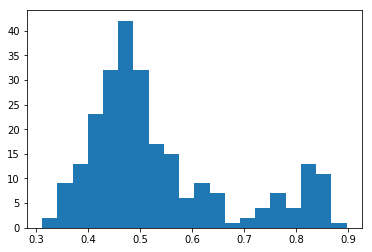

In [99]:
plt.hist(adapt_score_fusion, bins=20)
plt.show()

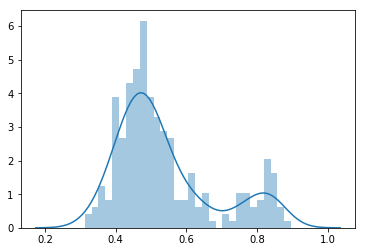

In [100]:
import seaborn as sns
sns.distplot(adapt_score_fusion, bins=30, kde=True )

In [103]:
from sklearn.neighbors.kde import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(adapt_score_fusion.reshape(-1, 1))

### Linear regression 

In [161]:
from sklearn.linear_model import LogisticRegressionCV

X = run_trial(total_enr_embeds, test_embeds, test_trial[1], threshold=vT).T

X_tr = X[:200]
y_tr = test_score_fusion[:200] > vT

X_te = X[200:]
y_te = test_trial[1][200:] # true_label

clf = LogisticRegressionCV(cv=5, random_state=0,
                           multi_class='multinomial').fit(X_tr, y_tr)

reg_scores = clf.predict_proba(X_te)[:,1]

NameError: name 'fpr' is not defined

## Searching the best enrollmnet

In [64]:
test_labels = np.array(test_trial[1])

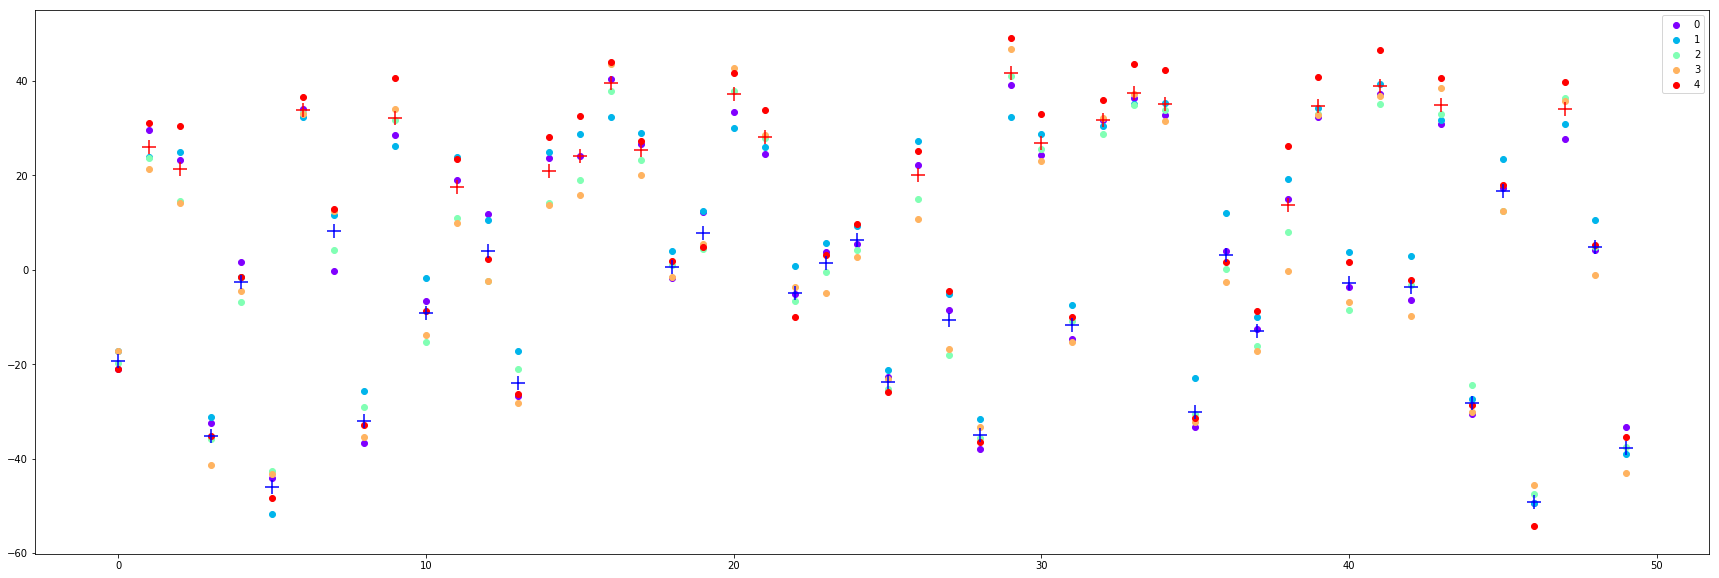

In [65]:
scores_subset = total_test_scores[0:5, 0:50]
labels_subset = test_labels[0:50]
plt.figure(figsize=(30, 10))
x = np.arange(scores_subset.shape[1])
ys = scores_subset
colors = cm.rainbow(np.linspace(0, 1, len(ys)))
s_set = []
for y, c in zip(ys, colors):
    s = plt.scatter(x, y, color=c)
    s_set.append(s)
plt.legend(s_set, range(len(s_set)))
y_mean = scores_subset.mean(0)
plt.scatter(x[labels_subset==1], y_mean[labels_subset==1], marker='+', s=200, color='r')
plt.scatter(x[labels_subset==0], y_mean[labels_subset==0], marker='+', s=200, color='b')

## Iterate trials

In [122]:
init_pos_scores = []
init_neg_scores = []
init_eers = []
total_pos_scores = []
total_neg_scores = []
total_eers = []

for i, tr in enumerate(trial):
    enr_spk, enr_ids, adapt_trial, test_trial = tr
    enr_embeds = get_embeds(enr_ids, sv_embeds, id2idx)
    
    adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, id2idx)
    adapt_scores = run_trial(enr_embeds, adapt_embeds, adapt_trial[1], threshold=vT, 
                             plot=False, verbose=False)
    adapt_enr_idx = np.nonzero(adapt_scores.mean(0) > eT)
    adapt_enr_embeds = adapt_embeds[adapt_enr_idx]
    
    ### score fusion
    total_enr_embeds = np.concatenate([enr_embeds, adapt_enr_embeds], axis=0)
    ### feat_fusion
    # total_enr_embeds = np.concatenate([enr_embeds, adapt_enr_embeds], axis=0).mean(0, keepdims=True)

    test_embeds = get_embeds(test_trial[0], sv_embeds, id2idx)
    test_labels = test_trial[1]
    test_scores = run_trial(enr_embeds, test_embeds, test_trial[1], threshold=vT, 
                            plot=False, verbose=False)
    test_score_fusion = test_scores.mean(0)
    init_pos_scores += test_score_fusion[test_labels==1].tolist()
    init_neg_scores += test_score_fusion[test_labels==0].tolist()
    init_eer = compute_eer(test_score_fusion[test_trial[1]==1], test_score_fusion[test_trial[1]==0])
    init_eers.append(init_eer)
    
    test_scores = run_trial(total_enr_embeds, test_embeds, test_trial[1], threshold=vT, 
                            plot=False, verbose=False)
    test_score_fusion = test_scores.mean(0)
    total_pos_scores += test_score_fusion[test_labels==1].tolist()
    total_neg_scores += test_score_fusion[test_labels==0].tolist() 
    total_eer = compute_eer(test_score_fusion[test_trial[1]==1], test_score_fusion[test_trial[1]==0])
    total_eers.append(total_eer)
    
#     print("[{}] init_eer:{:.4f}, total_eer:{:.4f}".format(i, init_eer, total_eer))

print("init_pooled_eer:{:.4f}, init_avg_eer:{:.4f}".format(compute_eer(init_pos_scores, init_neg_scores), np.mean(init_eers)))
print("total_pooled_eer:{:.4f}, total_avg_eer:{:.4f}".format(compute_eer(total_pos_scores, total_neg_scores), np.mean(total_eers)))

init_pooled_eer:0.0323, init_avg_eer:0.0242
total_pooled_eer:0.0106, total_avg_eer:0.0102
